In [1]:
#MODIFIED LOSS
#MIXUP
#image with padding 1

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
os.chdir('..')
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks import TrackerCallback
from fastai.callbacks import CSVLogger
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from utils.mxresnet import *
from utils.ranger import *
from sklearn.model_selection import StratifiedKFold, KFold
from joblib import load, dump
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pretrainedmodels

In [2]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [3]:
FOLD = 3
NAME = 'EXP_200'
SUFFIX =f'RESNEX_1CH_MISH_SIMPLE_CUTMIX_CUTOUT_MIXUP_NOCUTOUT_SIMPLE{FOLD}'
PATH = Path('../../../bengaliai')
SZ = 128
BS = 1024
NFOLDS = 5 #keep the same split as the initial dataset
SEED = 2019
TRAIN_IMG = PATH/'img_trn_orig'
LABELS = PATH/'train.csv'

os.chdir(NAME)

In [4]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def multi_strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [5]:
df = pd.read_csv(str(LABELS))
nunique = list(df.nunique())[1:-1]

In [6]:
val_idx = multi_strt_split(df['image_id'], df[df.columns[1:-1]].get_values())[FOLD]

/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  """Entry point for launching an IPython kernel.


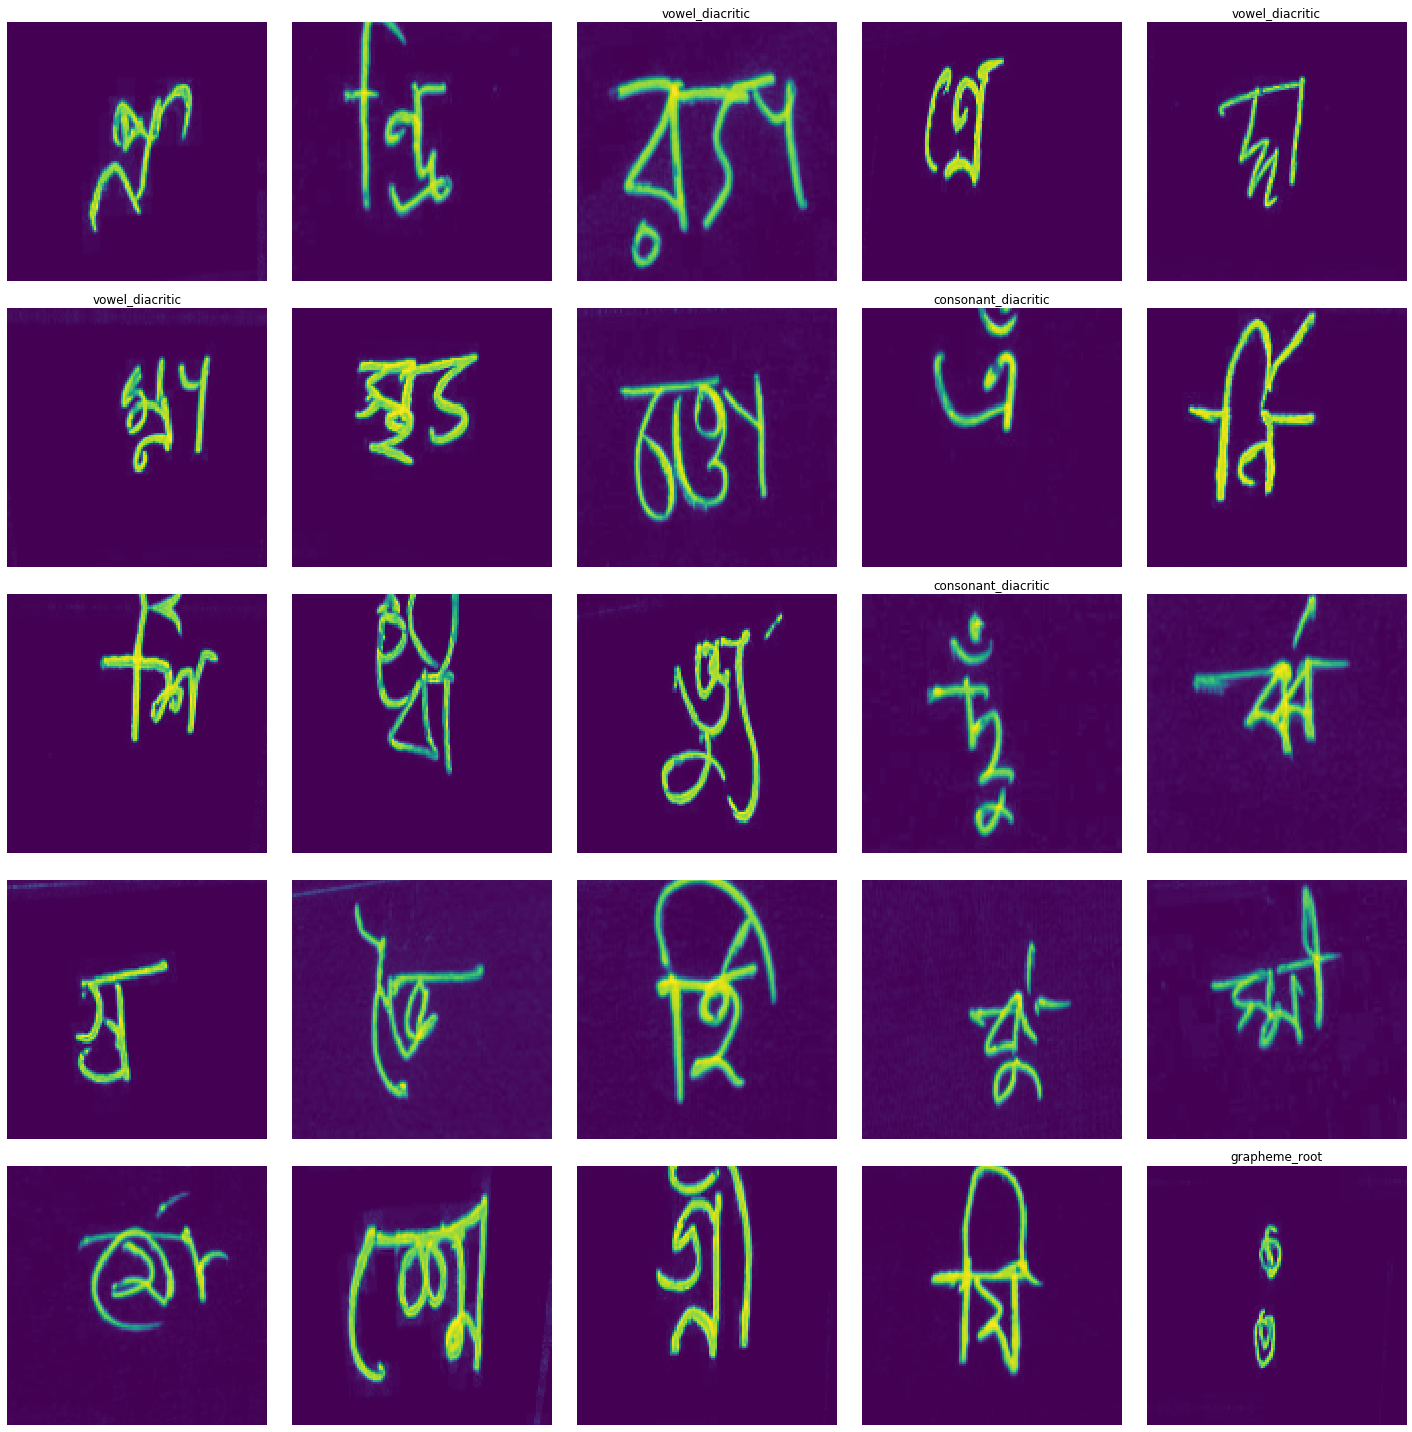

In [10]:
#imagenet_stats
data = (ImageList.from_df(df, path='', folder=TRAIN_IMG, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.2, max_zoom=1.1, max_rotate=5), size=(SZ, SZ), resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
        .databunch(bs=BS)).normalize(([0.0692], [0.2051]))

data.show_batch()

In [11]:
stats_ = data.stats
stats_
#size=(137, 236)

([0.0692], [0.2051])

In [29]:
class Head(nn.Module):
    def __init__(self, nc, n, ps=0.2):
        super().__init__()
        layers =[nn.Linear(nc*2, n)] 
        self.fc = nn.Sequential(*layers)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)
    
    
    
class CustomHead(nn.Module):
    def __init__(self, arch, cut, nc, n=nunique, pre=False, ps=0.5, activ_mish=True):
        super().__init__()
        self.body=nn.Sequential(*list(arch.children())[:cut], AdaptiveConcatPool2d(), Flatten())
        self.head1 = Head(nc,n[0])
        self.head2 = Head(nc,n[1])
        self.head3 = Head(nc,n[2])
        if activ_mish: 
            to_Mish(self.head1), to_Mish(self.head2), to_Mish(self.head3)
        
    def forward(self, x):
        x = self.body(x)
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        return x1, x2, x3

In [32]:
arch = pretrainedmodels.se_resnext50_32x4d(num_classes=1000)
arch = list(arch.children())
w = arch[0][0].weight
arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=2, bias=False)
arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
arch = nn.Sequential(*arch)
model = CustomHead(arch=arch, cut=-2, nc=2048)

In [33]:
model

CustomHead(
  (body): Sequential(
    (0): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(i

In [34]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return 0.7*F.cross_entropy(x1,y[:,0],reduction=reduction) + 0.1*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
          0.2*F.cross_entropy(x3,y[:,2],reduction=reduction)

In [35]:
class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())

In [36]:
class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3].long()), self.crit(output,target[:,3:6].long())
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  d = self.crit(output, target)
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class CutMixCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=1.0, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train or self.alpha == 0: return
        
        if random.random() > 0.5:
            λ = np.random.beta(self.alpha, self.alpha)
            λ = max(λ, 1- λ)
            bs = last_target.size(0)
            idx = torch.randperm(bs).to(last_input.device)
            x1, y1 = last_input[idx], last_target[idx]
            #Get new input
            last_input_size = last_input.size()
            bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
            new_input = last_input.clone()
            new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
            #λ = last_input.new([λ])
            λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
            λ = last_input.new([λ])

            # modify last target
            if self.stack_y:
                new_target = torch.cat([last_target.float(), y1.float(), λ.repeat(last_input_size[0])[:, None].float()], 1)
            else:
                if len(last_target.shape) == 2:
                    λ = λ.unsqueeze(1).float()
                new_target = last_target.float() * λ + y1.float() * (1-λ)

            return {'last_input': new_input, 'last_target': new_target}
        
        else:
            self.alpha  = 0.4
            lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
            lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
            lambd = last_input.new(lambd)
            shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
            x1, y1 = last_input[shuffle], last_target[shuffle]
            if self.stack_x:
                new_input = [last_input, last_input[shuffle], lambd]
            else: 
                out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
                new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
            if self.stack_y:
                new_target = torch.cat([last_target.float(), y1.float(), lambd[:,None].float()], 1)
            else:
                if len(last_target.shape) == 2:
                    lambd = lambd.unsqueeze(1).float()
                new_target = last_target.float() * lambd + y1.float() * (1-lambd)
            
            return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
            
def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''
    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    if len(last_input_size) == 4:
        bby2 = np.clip(cy + cut_h // 2, 0, H)
    else: bby2 = last_input_size[1]

    return bbx1, bby1, bbx2, bby2


In [37]:
def show_single_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    img = learn.data.train_ds.x
    tfms = learn.data.train_ds.tfms
    rand_int = np.random.randint(len(img))
    [img[rand_int].apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(
            plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
    plt.show()
    return learn

def show_multi_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    for cb in learn.callback_fns:
        try:
            cb_fn = partial(cb.func, **cb.keywords)
            [Image(cb_fn(learn).on_batch_begin(
                        xb, yb, True)['last_input'][0]).show(ax=ax)
                for i, ax in enumerate(
                    plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
            plt.show()
            break
        except:
            plt.close('all')
    return learn

def show_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    rand_int = np.random.randint(len(xb))
    ndim = xb.ndim
    tfms = learn.data.train_ds.tfms

    if ndim == 4:
        rand_item = Image(xb[rand_int])
        for i in range(len(xb)): xb[i] = Image(xb[i]).apply_tfms(tfms).data
        cb_tfms = 0
        for cb in learn.callback_fns:
            if hasattr(cb, 'keywords') and hasattr(get_fn(cb), 'on_batch_begin'):
                cb_fn = partial(get_fn(cb), **cb.keywords)
                try:
                    fig = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)[1].flatten()
                    plt.suptitle(get_fn(cb).__name__, size=14)
                    [Image(cb_fn(learn).on_batch_begin(xb, yb, True)['last_input'][0]).show(ax=ax)
                        for i, ax in enumerate(fig)]
                    plt.show()
                    cb_tfms += 1
                    break
                except:
                    plt.close('all')

    elif ndim == 3:
        rand_item = TimeSeriesItem(xb[rand_int])
        cb_tfms = 0
        for cb in learn.callback_fns:
            if hasattr(cb, 'keywords') and hasattr(get_fn(cb), 'on_batch_begin'):
                cb_fn = partial(get_fn(cb), **cb.keywords)
                try:
                    fig = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)[1].flatten()
                    plt.suptitle(get_fn(cb).__name__, size=14)
                    [TimeSeriesItem(cb_fn(learn).on_batch_begin(xb, yb, True)['last_input'][0]).show(ax=ax)
                        for i, ax in enumerate(fig)]
                    plt.show()
                    cb_tfms += 1
                    break
                except:
                    plt.close('all')

    if cb_tfms == 0:
        if tfms is not None:
            t_ = []
            for t in learn.data.train_ds.tfms: t_.append(get_fn(t).__name__)
            title = f"{str(t_)[1:-1]} transforms applied"
            fig = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)[1].flatten()
            [rand_item.apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(fig)]
            plt.suptitle(title, size=14)
            plt.show()
        else:
            print('No transformation has been applied')
            rand_item.show()

    return learn

def get_fn(a):
    while True:
        if hasattr(a, 'func'): a = a.func
        else: break
    return a


Learner.show_tfms = show_tfms
Learner.show_multi_img_tfms = show_multi_img_tfms
Learner.show_single_img_tfms = show_single_img_tfms

In [38]:
def cutmix(learn:Learner, alpha:float=1.0, stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add cutmix https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, alpha=alpha, stack_y=stack_y))
    return learn

setattr(cutmix, 'cb_fn', CutMixCallback)
Learner.cutmix = cutmix

In [39]:
learn = Learner(data, model, loss_func=Loss_combine(), opt_func = Over9000, 
        metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()]).cutmix()


learn.unfreeze()
learn.model = nn.DataParallel(learn.model)
#learn.lr_find(wd=1e-2)

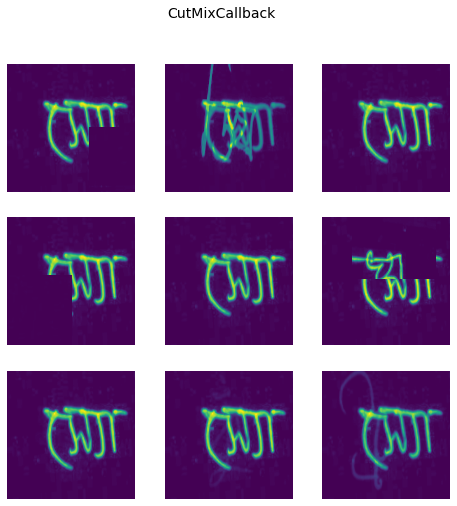

In [40]:
learn.show_tfms();

In [41]:
learn.unfreeze()
lr = 1e-1/4
learn.fit_one_cycle(100, lr, wd=1e-2,  pct_start=0.0,  div_factor=100, callbacks = [SaveModelCallback(learn, every='improvement', monitor='metric_tot', name = f'{NAME}_{SUFFIX}_{FOLD}')])

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.671727,0.414658,0.831585,0.919920,0.912865,0.873989,04:08
1,1.381311,0.236280,0.908515,0.958766,0.945417,0.930303,04:01
2,1.265200,0.258914,0.917566,0.961850,0.941177,0.934540,04:02
3,1.073915,0.196012,0.923526,0.967461,0.954514,0.942257,04:02
4,1.166066,0.219259,0.914113,0.968108,0.942019,0.934588,04:02
5,1.135302,0.183936,0.931165,0.970656,0.956081,0.947267,04:02


Better model found at epoch 0 with metric_tot value: 0.8739887475967407.
Better model found at epoch 1 with metric_tot value: 0.9303033947944641.
Better model found at epoch 2 with metric_tot value: 0.9345397353172302.
Better model found at epoch 3 with metric_tot value: 0.9422566294670105.
Better model found at epoch 5 with metric_tot value: 0.947266697883606.


KeyboardInterrupt: 

In [ ]:
!sudo shutdown